In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes)
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Combine features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

In [4]:
# Convert the target variable to binary
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [5]:
# 2. Data Cleaning
# Check for duplicates
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Handling missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

Number of duplicate rows: 0


In [6]:
# Feature Engineering: create interaction features between age, cholesterol, and chest pain type (cp)
df['age_chol_interaction'] = df['age'] * df['chol']
df['cp_trestbps_interaction'] = df['cp'] * df['trestbps']

In [7]:
# Perform one-hot encoding on specified categorical columns in df_balanced
# df = pd.get_dummies(df, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca'], drop_first=True)

In [8]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for scaling
numerical_features = df.select_dtypes(include=['float64', 'int']).columns.tolist()
numerical_features.remove('num') 

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [9]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num',
       'age_chol_interaction', 'cp_trestbps_interaction'],
      dtype='object')

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Select features and target variable
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal']

target = 'num'  # Replace with the name of your target variable

# Splitting the data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Create the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.87
Confusion Matrix:
 [[26  3]
 [ 5 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [14]:
# Initialize the XGBoost model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model on the training data
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8852459016393442
Confusion Matrix:
 [[27  2]
 [ 5 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



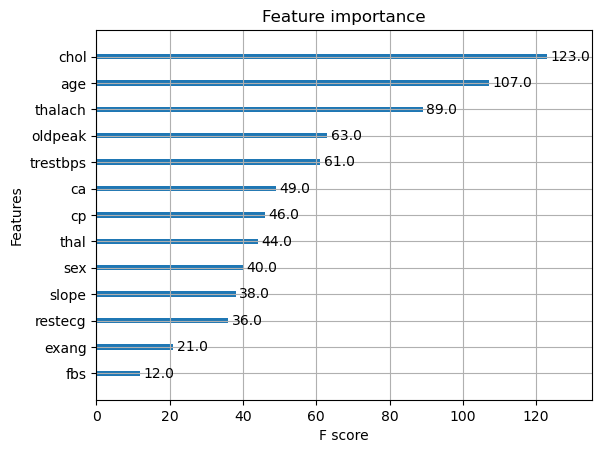

In [15]:
import matplotlib.pyplot as plt

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.86885246 0.85245902 0.78688525 0.73333333 0.78333333]
Mean cross-validation score: 0.8049726775956284


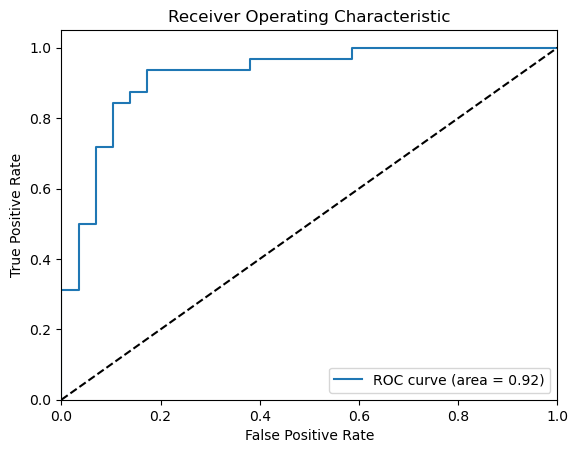

In [17]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Model Performance using SHAP 

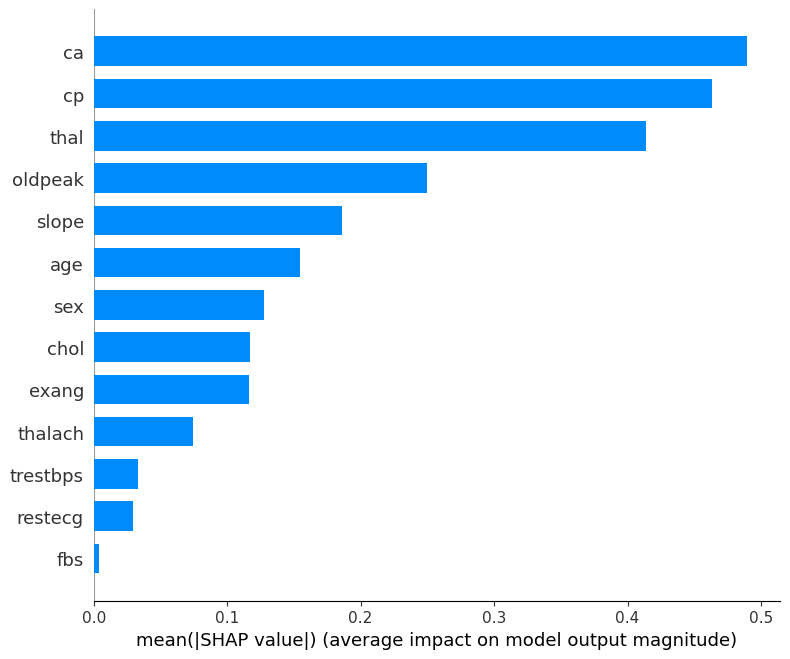

In [18]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance based on SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features)


In [19]:
import shap
shap.initjs()

# Force plot for a single prediction (e.g., the first sample in the test set)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

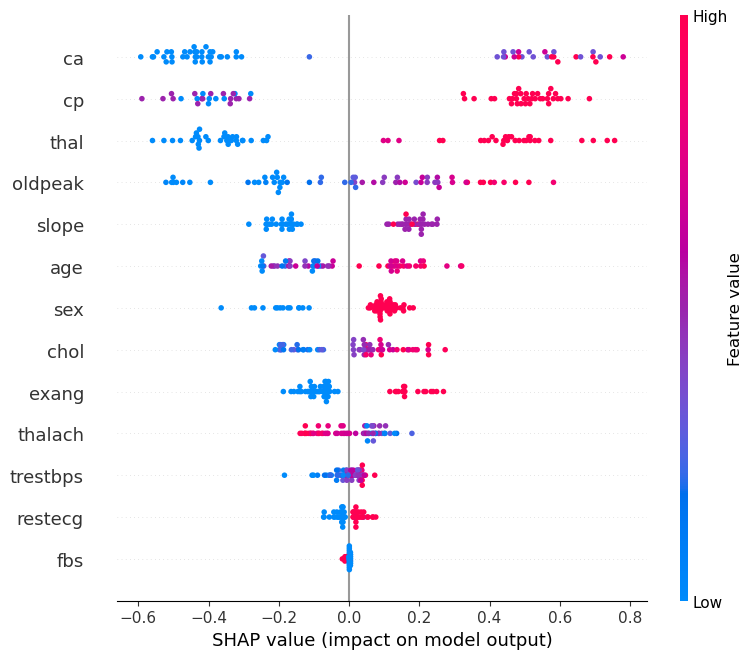

In [20]:
# Summary plot for global SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features)


Saving the model

In [21]:
import pickle

scaler = StandardScaler()
scaler.fit(X_train)  # Fit the scaler on training data

# Save the scaler object
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [22]:
import joblib

# Save the model
joblib.dump(grid_search.best_estimator_, 'xgb_model1.pkl')

['xgb_model1.pkl']